# **Thư viện**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.dates as mdates
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# **Dữ liệu**

In [2]:
df = pd.read_csv("../data/processed/EUR_VND_Exchange_Rate.csv", parse_dates=["Date"])
df["Date"] = pd.to_datetime(df["Date"])
timestamps = df["Date"].values   
df = df.set_index('Date')
df = df.select_dtypes(include=[np.number]).fillna(0).astype(np.float32)

df.tail()

,Sell
Date,
2025-04-07,29106.519531
2025-04-08,29215.210938
2025-04-09,29443.519531
2025-04-10,29178.759766
2025-04-11,29775.689453


# **Tạo Lags**


In [3]:
lags = 30
for i in range(1, lags + 1):
    df[f'lag_{i}'] = df['Sell'].shift(i)
df.dropna(inplace=True)  


In [4]:
X = df.drop(columns=['Sell']).values
y = df['Sell'].values

# **Train/Test**

In [5]:
timestamps = df.dropna().index 

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Lấy timestamps tương ứng
train_timestamps = timestamps[:train_size]
test_timestamps = timestamps[train_size:]


# **Huấn luyện mô hình XGBoost**


In [6]:
def train_xgb(X_train, y_train, model_path):
    """
    Huấn luyện XGBoost và lưu mô hình với tham số tối ưu
    """
    # param_grid = {
    #     'n_estimators': [100, 200, 300, 400, 500],
    #     'max_depth': [3, 5, 7, 10],
    #     'learning_rate': [0.01, 0.05, 0.1],
    #     'subsample': [0.8, 1.0],
    #     'colsample_bytree': [0.8, 1.0],
    #     'reg_alpha': [0, 0.1, 1],
    #     'reg_lambda': [0, 0.1, 1]
    # }

    param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0],
    'reg_lambda': [1]
    }   
    
    
    model = xgb.XGBRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    joblib.dump(best_model, model_path)

    return best_model

In [7]:
def build_xgb_model(best_hp):
    """
    Xây dựng mô hình XGBoost từ tham số tối ưu
    """
    model = xgb.XGBRegressor(
        n_estimators=best_hp.n_estimators,
        max_depth=best_hp.max_depth,
        learning_rate=best_hp.learning_rate,
        subsample=best_hp.subsample,
        colsample_bytree=best_hp.colsample_bytree,
        reg_alpha=best_hp.reg_alpha,
        reg_lambda=best_hp.reg_lambda,
        random_state=42
    )
    return model

In [8]:
model_path = r"D:\eur-vnd-exchange-rate\models\XGBoost\best_xgb_prices.pkl"
best_model = train_xgb(X_train, y_train, model_path)
best_model.get_params()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

# **Đánh giá mô hình**

In [9]:
y_pred_test = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"MAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}\nR^2: {r2:.4f}\nMAPE: {mape:.4f} ({mape * 100:.2f}%)")


MAE: 79.1467
MSE: 15527.2344
RMSE: 124.6083
R^2: 0.9481
MAPE: 0.0028 (0.28%)


# **Dự đoán và Thực tế**


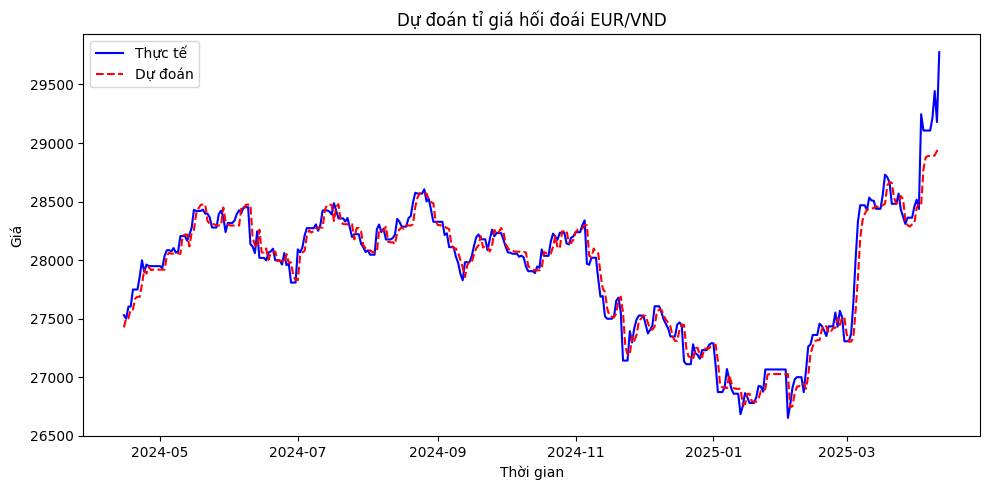

In [10]:
y_pred_test = best_model.predict(X_test)

# Đảm bảo test_timestamps là datetime
test_timestamps = pd.to_datetime(test_timestamps)

plt.figure(figsize=(10, 5))
plt.plot(test_timestamps, y_test, label="Thực tế", color="blue")
plt.plot(test_timestamps, y_pred_test, label="Dự đoán", linestyle="dashed", color="red")

plt.xlabel("Thời gian")
plt.ylabel("Giá")
plt.title("Dự đoán tỉ giá hối đoái EUR/VND")

plt.legend()
plt.tight_layout()
plt.show()


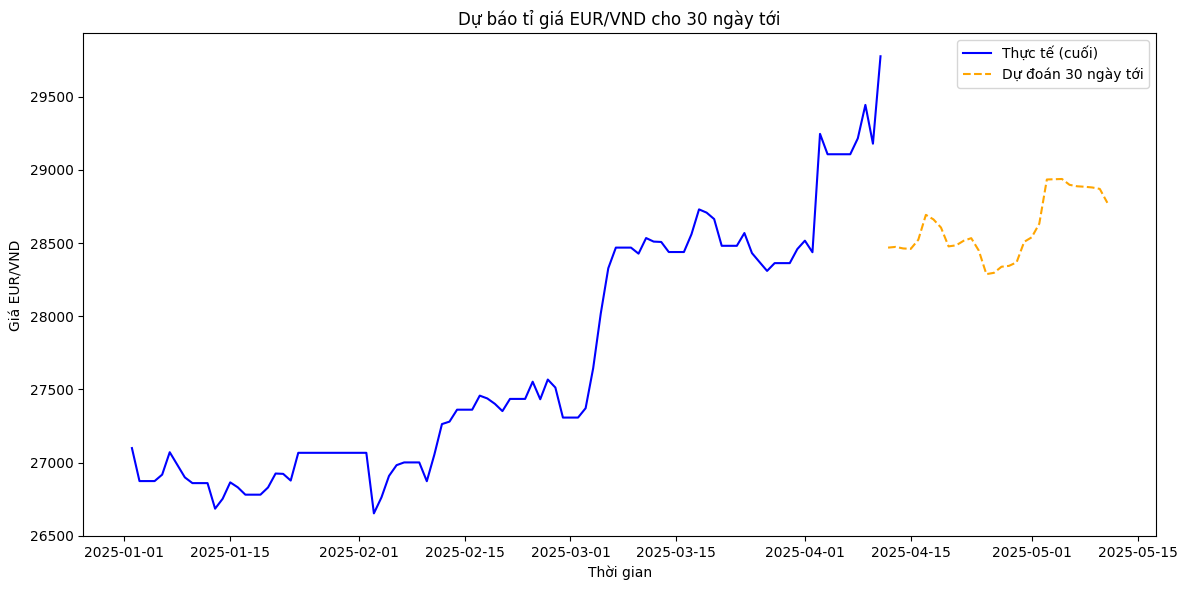

In [11]:
from datetime import timedelta

# Lấy 30 giá trị gần nhất để bắt đầu dự báo
last_known = df['Sell'].values[-lags:].tolist()  # danh sách 30 giá trị gần nhất

future_preds = []  # lưu dự đoán
future_dates = []  # lưu ngày tương ứng

# Ngày bắt đầu là ngày cuối cùng trong dữ liệu
last_date = df.index[-1]

for i in range(30):
    # Tạo input với 30 giá trị lag gần nhất
    input_features = np.array(last_known[-lags:]).reshape(1, -1)

    # Dự đoán ngày tiếp theo
    pred = best_model.predict(input_features)[0]

    # Lưu kết quả
    future_preds.append(pred)
    last_known.append(pred)  # cập nhật vào danh sách để tiếp tục dùng cho lần sau
    future_dates.append(last_date + timedelta(days=i+1))  # ngày dự đoán tiếp theo

# Chuyển thành DataFrame để tiện sử dụng
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Sell': future_preds
}).set_index('Date')

# Vẽ biểu đồ nối tiếp
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['Sell'].values[-100:], label='Thực tế (cuối)', color='blue')
plt.plot(future_df.index, future_df['Predicted_Sell'], label='Dự đoán 30 ngày tới', color='orange', linestyle='--')

plt.xlabel("Thời gian")
plt.ylabel("Giá EUR/VND")
plt.title("Dự báo tỉ giá EUR/VND cho 30 ngày tới")
plt.legend()
plt.tight_layout()
plt.show()
